# Harmonic splitter

Go through either experimental or simulation data to isolate the frequencies.

## Read settings

Read file names and parameters from settings file made by GenerateScript

Filenames set by input argument either simulation or experiment

In [1]:
lines = [line.rstrip('\n') for line in open('Settings.inp')]
filename = lines[0].strip().split()[0]
number_harmonics = int(lines[1].strip().split()[0])
frequency_bandwidth = float(lines[2].strip().split()[0])
filename_exp = lines[3].strip().split()[0]
filename_sim = lines[4].strip().split()[0]
results_name = lines[5].strip().split()[0]


In [2]:
results_name

'results.txt'

### Load packages

In [58]:
# import required python packages
import numpy as np
from scipy.fftpack import rfft, irfft, fftfreq


## Define functions

Read the data file using the format from POT software also used as default by MECSim. Time, current then applied potential

In [59]:
# load POT output file
# t_MS2, i_MS2, e_MS2 = ReadPOTFile('Raw/GC06_FeIII-1mM_1M-KCl_02_009Hz.txt', tmin, tmax)
def ReadPOTFileFreq(filename):
    f = open(filename, 'r')
    time = []
    eapp = []
    current = []
    freq = []
    amp = []
    phase = []
    nfreq = 0
    iCount = 0
    iAll = 0
    for line in f:
        columns = line.split()
        if(columns[0][3:7].isdigit()): # look at 2nd character in case Eapp is "-"
            thisTime = float(columns[2])
            time.append(thisTime)
            eapp.append(float(columns[0]))
            current.append(float(columns[1]))
            iCount += 1
        else:
            if(columns[0][0:3]=='Fre'):
                freq.append(float(columns[1]))
            if(columns[0][0:3]=='Amp'):
                amp.append(float(columns[1]))
                if(amp[-1]!=0.0):
                    nfreq += 1
            if(columns[0][0:3]=='Pha'):
                phase.append(float(columns[1])) # not always there
        iAll += 1
    return iCount, nfreq, freq, amp, time, current, eapp

Smooth the current as an envelope of the current as a function of time

In [60]:
def SmoothCurrent(t, i, e, tWindow):
    iSmooth = list(i)
    deltaT = t[1]-t[0] # assumes constant time steps
    tEnd = t[-1]
    tStart = t[0]
    iWindow = int(tWindow/deltaT)+1
    windowVal = []
    iMax = len(t)
    iMinW = -iWindow/2
    iMaxW = iMinW+iWindow-1
    for j in range(0, iWindow):
        windowVal.insert(0, i[j]) # insert at top/pop from bottom
    for ii in range(iMax):
        iMinW += 1
        iMaxW += 1
        if((iMinW>0) and (iMaxW<iMax)): # shift running total across by one point
            windowVal.pop()
            windowVal.insert(0, i[iMaxW])
        iSmooth[ii] = max(windowVal)
    return iSmooth

## Read data file

In [61]:
iCount, nfreq, freq, amp, time, current, eapp = ReadPOTFileFreq(filename)
t = np.array(time)
c = np.array(current)
ea = np.array(eapp)

In [62]:
n_data_length = len(t)
#nfreq, freq[0:nfreq], amp[0:nfreq]
print n_data_length

65536


Isolate ac fundamental frequencies
---

In [63]:
freqMin = min(freq[0:nfreq])
tWindow = 1.0/freqMin
print 'f_min = ',freqMin,' ; t_window = ',tWindow

f_min =  9.015203  ; t_window =  0.110923736271


FFT of the time series data
---

Single frequency is assumed for now. Do all harmonics of it (and dc).

In [64]:
i_Harm = []
c_Harm = []

W = fftfreq(c.size, d=2*(t[1]-t[0]))
f_signal = rfft(c)
cut_f_signal = f_signal.copy()
cut_f_signal[(W>0.5*freq[0])] = 0
cut_signal = irfft(cut_f_signal)

c_Harm.append(cut_signal)
i_Harm.append(SmoothCurrent(t, cut_signal, eapp, tWindow))

for iH in range(number_harmonics):
    iHarm = iH + 1
    fH = float(iHarm)
    W = fftfreq(c.size, d=2*(t[1]-t[0]))
    f_signal = rfft(c)
    cut_f_signal = f_signal.copy()
    cut_f_signal[(W<(fH*freq[0]-frequency_bandwidth))] = 0
    cut_f_signal[(W>(fH*freq[0]+frequency_bandwidth))] = 0
    cut_signal = irfft(cut_f_signal)
    c_Harm.append(cut_signal)
    i_Harm.append(SmoothCurrent(t, cut_signal, eapp, tWindow))


Save relevant data

In [65]:
data_output = t
for i in range(number_harmonics+1):
    data_output = np.concatenate((data_output, i_Harm[i]), axis=0)

data_output = np.reshape(data_output, (number_harmonics+2, n_data_length))
data_output = data_output.T
np.savetxt( 'Smoothed.txt', data_output)

## Use interactive plotter

ONLY if not using this in bash script

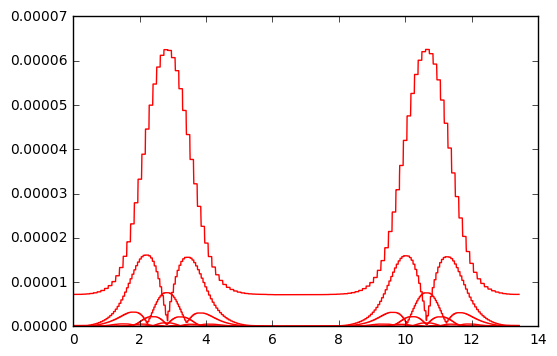

In [66]:
plotInteractive = True
if(plotInteractive):
    import matplotlib.pyplot as plt
    %matplotlib inline
    for i in range(number_harmonics):
        iH = i+1
        plt.plot(t, i_Harm[iH],c='r')
    plt.show()

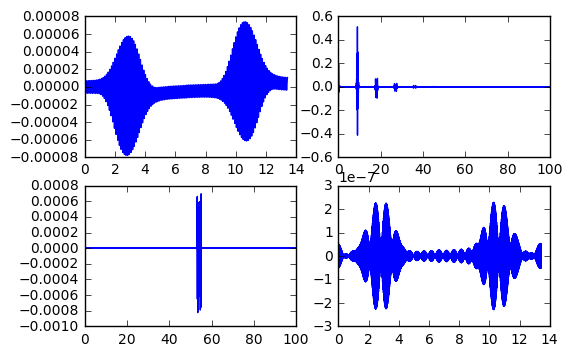

In [67]:
if(plotInteractive):
    plt.subplot(221)
    plt.plot(t,c)
    plt.subplot(222)
    plt.plot(W,f_signal)
    plt.xlim(0,100)
    plt.subplot(223)
    plt.plot(W,cut_f_signal)
    plt.xlim(0,100)
    plt.subplot(224)
    plt.plot(t,cut_signal)
    plt.show()

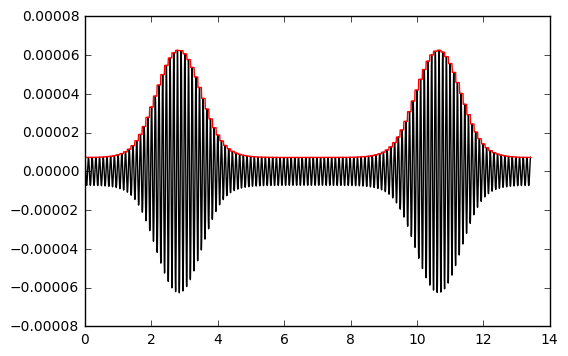

In [68]:
if(plotInteractive):
    iH = 1
    plt.plot(t, c_Harm[iH],c='k')
    plt.plot(t, i_Harm[iH],c='r')
    plt.show()